# Kaggle competition restaurant visitor forecasting competition
https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting

In [171]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap, MDS
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
import umap
from sklearn.ensemble import IsolationForest

# format notebook output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.core.display import display, HTML, Javascript
display(HTML("<style>.container { width:90% !important; }</style>"))

# style pandas display
pd.set_option('display.max_columns', None)

# matplotlib magic
%matplotlib inline

In [3]:
def desc(df):
    display(df.head())
    print(df.shape)
    print(df.dtypes)

# Load data

In [4]:
air_reserve = pd.read_csv('../../data_files/air_reserve.csv')
air_store_info = pd.read_csv('../../data_files/air_store_info.csv', encoding='utf-8')
air_visit_data = pd.read_csv('../../data_files/air_visit_data.csv')
date_info = pd.read_csv('../../data_files/date_info.csv')
hpg_reserve = pd.read_csv('../../data_files/hpg_reserve.csv')
hpg_store_info = pd.read_csv('../../data_files/hpg_store_info.csv')
sample_submission = pd.read_csv('../../data_files/sample_submission.csv')
store_id_relation = pd.read_csv('../../data_files/store_id_relation.csv')

# Feature extraction with TSFRESH

In [5]:
extracted_features = extract_features(air_visit_data, column_id="air_store_id", column_sort="visit_date")

Feature Extraction: 100%|██████████| 20/20 [01:42<00:00,  5.11s/it]


In [19]:
zero_variance_features = extracted_features.var().iloc[np.where(extracted_features.var() == 0)].index

In [23]:
extracted_features = extracted_features[[col for col in extracted_features.columns if col not in zero_variance_features]]

In [24]:
desc(extracted_features)

variable,visitors__abs_energy,visitors__absolute_sum_of_changes,"visitors__agg_autocorrelation__f_agg_""mean""","visitors__agg_autocorrelation__f_agg_""median""","visitors__agg_autocorrelation__f_agg_""var""","visitors__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","visitors__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","visitors__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","visitors__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""","visitors__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""intercept""","visitors__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""rvalue""","visitors__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""slope""","visitors__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""stderr""","visitors__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""intercept""","visitors__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""rvalue""","visitors__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""slope""","visitors__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""stderr""","visitors__agg_linear_trend__f_agg_""mean""__chunk_len_10__attr_""intercept""","visitors__agg_linear_trend__f_agg_""mean""__chunk_len_10__attr_""rvalue""","visitors__agg_linear_trend__f_agg_""mean""__chunk_len_10__attr_""slope""","visitors__agg_linear_trend__f_agg_""mean""__chunk_len_10__attr_""stderr""","visitors__agg_linear_trend__f_agg_""mean""__chunk_len_50__attr_""intercept""","visitors__agg_linear_trend__f_agg_""mean""__chunk_len_50__attr_""rvalue""","visitors__agg_linear_trend__f_agg_""mean""__chunk_len_50__attr_""slope""","visitors__agg_linear_trend__f_agg_""mean""__chunk_len_50__attr_""stderr""","visitors__agg_linear_trend__f_agg_""mean""__chunk_len_5__attr_""intercept""","visitors__agg_linear_trend__f_agg_""mean""__chunk_len_5__attr_""rvalue""","visitors__agg_linear_trend__f_agg_""mean""__chunk_len_5__attr_""slope""","visitors__agg_linear_trend__f_agg_""mean""__chunk_len_5__attr_""stderr""","visitors__agg_linear_trend__f_agg_""min""__chunk_len_10__attr_""intercept""","visitors__agg_linear_trend__f_agg_""min""__chunk_len_10__attr_""rvalue""","visitors__agg_linear_trend__f_agg_""min""__chunk_len_10__attr_""slope""","visitors__agg_linear_trend__f_agg_""min""__chunk_len_10__attr_""stderr""","visitors__agg_linear_trend__f_agg_""min""__chunk_len_50__attr_""intercept""","visitors__agg_linear_trend__f_agg_""min""__chunk_len_50__attr_""rvalue""","visitors__agg_linear_trend__f_agg_""min""__chunk_len_50__attr_""slope""","visitors__agg_linear_trend__f_agg_""min""__chunk_len_50__attr_""stderr""","visitors__agg_linear_trend__f_agg_""min""__chunk_len_5__attr_""intercept""","visitors__agg_linear_trend__f_agg_""min""__chunk_len_5__attr_""rvalue""","visitors__agg_linear_trend__f_agg_""min""__chunk_len_5__attr_""slope""","visitors__agg_linear_trend__f_agg_""min""__chunk_len_5__attr_""stderr""","visitors__agg_linear_trend__f_agg_""var""__chunk_len_10__attr_""intercept""","visitors__agg_linear_trend__f_agg_""var""__chunk_len_10__attr_""rvalue""","visitors__agg_linear_trend__f_agg_""var""__chunk_len_10__attr_""slope""","visitors__agg_linear_trend__f_agg_""var""__chunk_len_10__attr_""stderr""","visitors__agg_linear_trend__f_agg_""var""__chunk_len_50__attr_""intercept""","visitors__agg_linear_trend__f_agg_""var""__chunk_len_50__attr_""rvalue""","visitors__agg_linear_trend__f_agg_""var""__chunk_len_50__attr_""slope""","visitors__agg_linear_trend__f_agg_""var""__chunk_len_50__attr_""stderr""","visitors__agg_linear_trend__f_agg_""var""__chunk_len_5__attr_""intercept""","visitors__agg_linear_trend__f_agg_""var""__chunk_len_5__attr_""rvalue""","visitors__agg_linear_trend__f_agg_""var""__chunk_len_5__attr_""slope""","visitors__agg_linear_trend__f_agg_""var""__chunk_len_5__attr_""stderr""",visitors__approximate_entropy__m_2__r_0.1,visitors__approximate_entropy__m_2__r_0.3,visitors__approximate_entropy__m_2__r_0.5,visitors__approximate_entropy__m_2__r_0.7,vis

(829, 710)
variable
visitors__abs_energy                                                        float64
visitors__absolute_sum_of_changes                                           float64
visitors__agg_autocorrelation__f_agg_"mean"                                 float64
visitors__agg_autocorrelation__f_agg_"median"                               float64
visitors__agg_autocorrelation__f_agg_"var"                                  float64
visitors__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"intercept"     float64
visitors__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"        float64
visitors__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"         float64
visitors__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"        float64
visitors__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"intercept"     float64
visitors__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"        float64
visitors__agg_linear_trend__f_agg_"max"__chunk_len_50__a

In [30]:
extracted_features.isnull().sum().sort_values(ascending=False)

variable
visitors__friedrich_coefficients__m_3__r_30__coeff_3    686
visitors__friedrich_coefficients__m_3__r_30__coeff_2    686
visitors__friedrich_coefficients__m_3__r_30__coeff_1    686
visitors__friedrich_coefficients__m_3__r_30__coeff_0    686
visitors__max_langevin_fixed_point__m_3__r_30           686
visitors__fft_coefficient__coeff_99__attr_"real"         62
visitors__fft_coefficient__coeff_99__attr_"imag"         62
visitors__fft_coefficient__coeff_99__attr_"angle"        62
visitors__fft_coefficient__coeff_99__attr_"abs"          62
visitors__fft_coefficient__coeff_98__attr_"angle"        61
visitors__fft_coefficient__coeff_98__attr_"abs"          61
visitors__fft_coefficient__coeff_98__attr_"imag"         61
visitors__fft_coefficient__coeff_98__attr_"real"         61
visitors__fft_coefficient__coeff_97__attr_"real"         57
visitors__fft_coefficient__coeff_97__attr_"imag"         57
visitors__fft_coefficient__coeff_97__attr_"angle"        57
visitors__fft_coefficient__coef

In [32]:
large_null_cols = [
    'visitors__friedrich_coefficients__m_3__r_30__coeff_3',
    'visitors__friedrich_coefficients__m_3__r_30__coeff_2',
    'visitors__friedrich_coefficients__m_3__r_30__coeff_1',
    'visitors__friedrich_coefficients__m_3__r_30__coeff_0',
    'visitors__max_langevin_fixed_point__m_3__r_30'
]

In [36]:
extracted_features = extracted_features[[col for col in extracted_features.columns if col not in large_null_cols]]

In [37]:
desc(extracted_features)

variable,visitors__abs_energy,visitors__absolute_sum_of_changes,"visitors__agg_autocorrelation__f_agg_""mean""","visitors__agg_autocorrelation__f_agg_""median""","visitors__agg_autocorrelation__f_agg_""var""","visitors__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","visitors__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","visitors__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","visitors__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""","visitors__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""intercept""","visitors__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""rvalue""","visitors__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""slope""","visitors__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""stderr""","visitors__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""intercept""","visitors__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""rvalue""","visitors__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""slope""","visitors__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""stderr""","visitors__agg_linear_trend__f_agg_""mean""__chunk_len_10__attr_""intercept""","visitors__agg_linear_trend__f_agg_""mean""__chunk_len_10__attr_""rvalue""","visitors__agg_linear_trend__f_agg_""mean""__chunk_len_10__attr_""slope""","visitors__agg_linear_trend__f_agg_""mean""__chunk_len_10__attr_""stderr""","visitors__agg_linear_trend__f_agg_""mean""__chunk_len_50__attr_""intercept""","visitors__agg_linear_trend__f_agg_""mean""__chunk_len_50__attr_""rvalue""","visitors__agg_linear_trend__f_agg_""mean""__chunk_len_50__attr_""slope""","visitors__agg_linear_trend__f_agg_""mean""__chunk_len_50__attr_""stderr""","visitors__agg_linear_trend__f_agg_""mean""__chunk_len_5__attr_""intercept""","visitors__agg_linear_trend__f_agg_""mean""__chunk_len_5__attr_""rvalue""","visitors__agg_linear_trend__f_agg_""mean""__chunk_len_5__attr_""slope""","visitors__agg_linear_trend__f_agg_""mean""__chunk_len_5__attr_""stderr""","visitors__agg_linear_trend__f_agg_""min""__chunk_len_10__attr_""intercept""","visitors__agg_linear_trend__f_agg_""min""__chunk_len_10__attr_""rvalue""","visitors__agg_linear_trend__f_agg_""min""__chunk_len_10__attr_""slope""","visitors__agg_linear_trend__f_agg_""min""__chunk_len_10__attr_""stderr""","visitors__agg_linear_trend__f_agg_""min""__chunk_len_50__attr_""intercept""","visitors__agg_linear_trend__f_agg_""min""__chunk_len_50__attr_""rvalue""","visitors__agg_linear_trend__f_agg_""min""__chunk_len_50__attr_""slope""","visitors__agg_linear_trend__f_agg_""min""__chunk_len_50__attr_""stderr""","visitors__agg_linear_trend__f_agg_""min""__chunk_len_5__attr_""intercept""","visitors__agg_linear_trend__f_agg_""min""__chunk_len_5__attr_""rvalue""","visitors__agg_linear_trend__f_agg_""min""__chunk_len_5__attr_""slope""","visitors__agg_linear_trend__f_agg_""min""__chunk_len_5__attr_""stderr""","visitors__agg_linear_trend__f_agg_""var""__chunk_len_10__attr_""intercept""","visitors__agg_linear_trend__f_agg_""var""__chunk_len_10__attr_""rvalue""","visitors__agg_linear_trend__f_agg_""var""__chunk_len_10__attr_""slope""","visitors__agg_linear_trend__f_agg_""var""__chunk_len_10__attr_""stderr""","visitors__agg_linear_trend__f_agg_""var""__chunk_len_50__attr_""intercept""","visitors__agg_linear_trend__f_agg_""var""__chunk_len_50__attr_""rvalue""","visitors__agg_linear_trend__f_agg_""var""__chunk_len_50__attr_""slope""","visitors__agg_linear_trend__f_agg_""var""__chunk_len_50__attr_""stderr""","visitors__agg_linear_trend__f_agg_""var""__chunk_len_5__attr_""intercept""","visitors__agg_linear_trend__f_agg_""var""__chunk_len_5__attr_""rvalue""","visitors__agg_linear_trend__f_agg_""var""__chunk_len_5__attr_""slope""","visitors__agg_linear_trend__f_agg_""var""__chunk_len_5__attr_""stderr""",visitors__approximate_entropy__m_2__r_0.1,visitors__approximate_entropy__m_2__r_0.3,visitors__approximate_entropy__m_2__r_0.5,visitors__approximate_entropy__m_2__r_0.7,vis

(829, 705)
variable
visitors__abs_energy                                                        float64
visitors__absolute_sum_of_changes                                           float64
visitors__agg_autocorrelation__f_agg_"mean"                                 float64
visitors__agg_autocorrelation__f_agg_"median"                               float64
visitors__agg_autocorrelation__f_agg_"var"                                  float64
visitors__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"intercept"     float64
visitors__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"        float64
visitors__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"         float64
visitors__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"        float64
visitors__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"intercept"     float64
visitors__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"        float64
visitors__agg_linear_trend__f_agg_"max"__chunk_len_50__a

In [38]:
extracted_features = impute(extracted_features)

In [133]:
extracted_features = pd.merge(
    left=extracted_features,
    right=air_store_info.set_index('air_store_id'),
    left_index=True,
    right_index=True,
    copy=False
)

In [137]:
genre_encoder = LabelEncoder()

extracted_features['air_genre_name'] = genre_encoder.fit_transform(extracted_features['air_genre_name'].values)

In [140]:
area_encoder = LabelEncoder()

extracted_features['air_area_name'] = genre_encoder.fit_transform(extracted_features['air_area_name'].values)

# Dimension reduction

## PCA

In [141]:
pca = PCA(n_components=2, random_state=42)

X = extracted_features.values
pca_reduced = pca.fit_transform(X)

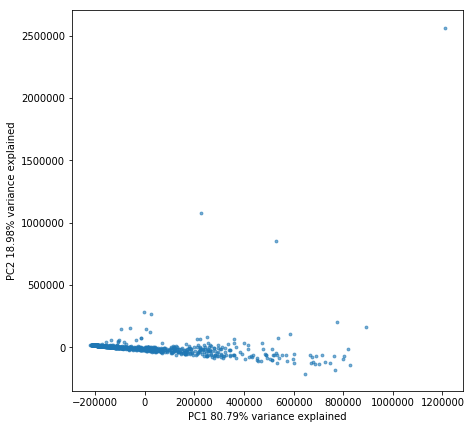

In [142]:
pc1_col = 'PC1 ' + '%.2f' % (pca.explained_variance_ratio_[0]*100) + '% variance explained'
pc2_col = 'PC2 ' + '%.2f' % (pca.explained_variance_ratio_[1]*100) + '% variance explained'

pd.DataFrame(pca_reduced).rename(columns={0: pc1_col, 1: pc2_col}).plot(
    kind='scatter',
    x=pc1_col,
    y=pc2_col,
    figsize=(7, 7),
    s=8,
    alpha=0.6
);

## UMAP

In [143]:
umap_embedding = umap.UMAP(n_neighbors=7,
                           min_dist=0.3,
                           metric='euclidean').fit_transform(extracted_features)

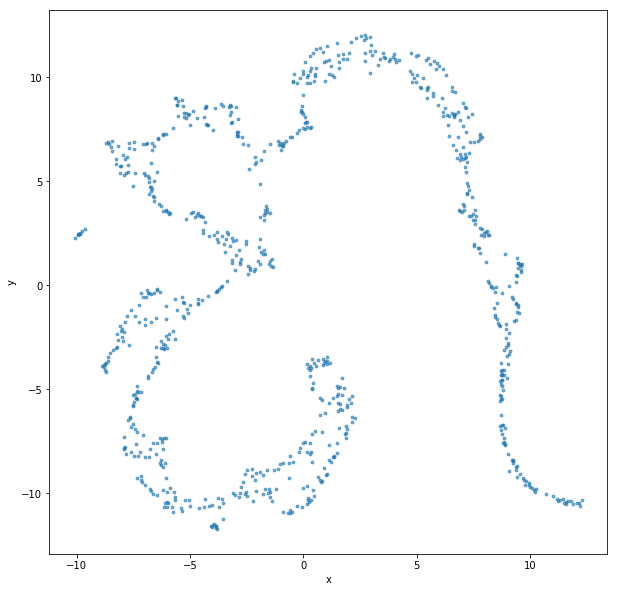

In [144]:
pd.DataFrame(umap_embedding).rename(columns={0: 'x', 1: 'y'}).plot(
    kind='scatter',
    x='x',
    y='y',
    figsize=(10,10),
    s=8,
    alpha=0.6
);

In [145]:
sil_scores = []

for k in range(2, 30):
    kmeans = KMeans(
        n_clusters=k,
        random_state=42
    );

    kmeans.fit(umap_embedding);
    
    sil_score = silhouette_score(umap_embedding, kmeans.predict(umap_embedding))
    
    sil_scores.append((k, sil_score))   

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=9, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=11, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=12, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=13, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=14, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=15, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=16, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=17, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=18, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=19, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=21, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=22, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=23, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=24, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=25, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=26, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=27, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=28, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=29, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

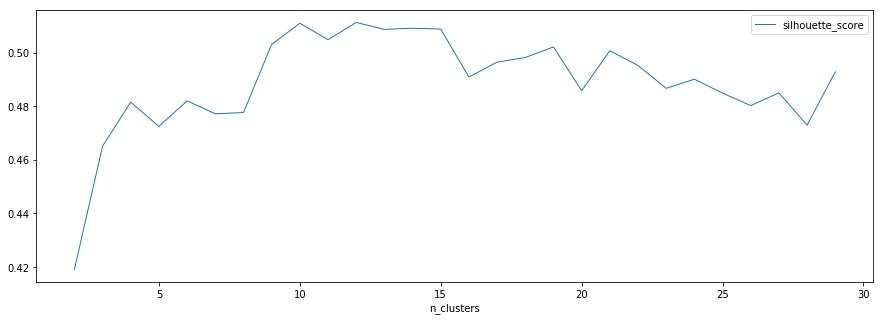

In [146]:
pd.DataFrame(sil_scores).rename(columns={0: 'n_clusters', 1: 'silhouette_score'}).plot(
    kind='line',
    lw=1,
    x='n_clusters',
    figsize=(15, 5)
);

In [147]:
pd.DataFrame(sil_scores).rename(columns={0: 'n_clusters', 1: 'silhouette_score'}).sort_values('silhouette_score', ascending=False).head(2)

,n_clusters,silhouette_score
10,12,0.511226
8,10,0.510930


So choose `n_clusters == 10`

In [148]:
kmeans = KMeans(n_clusters=10, random_state=42)

clusters = kmeans.fit_predict(umap_embedding)

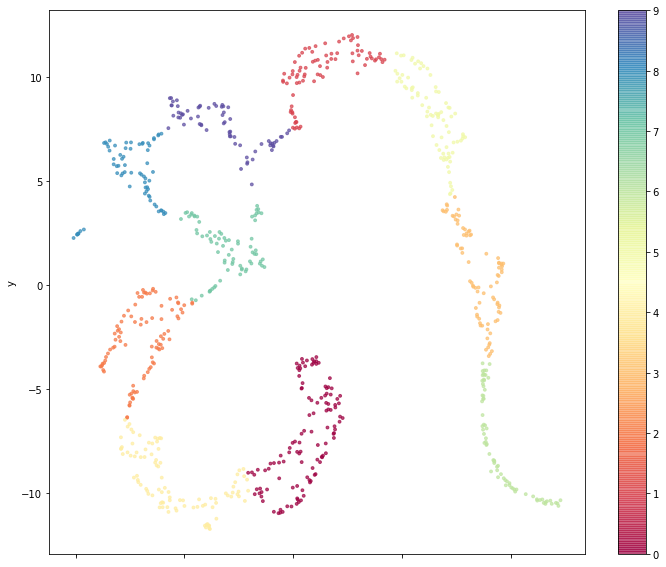

In [149]:
pd.DataFrame(umap_embedding).rename(columns={0: 'x', 1: 'y'}).plot(
    kind='scatter',
    x='x',
    y='y',
    figsize=(12,10),
    s=8,
    alpha=0.7,
    c=clusters,
    cmap='Spectral'
);

In [193]:
gm = GaussianMixture(
    n_components=10,
    covariance_type='full',
    random_state=42
)

X = umap_embedding
gm.fit(X)

clusters = gm.predict(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=10, n_init=1, precisions_init=None,
        random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

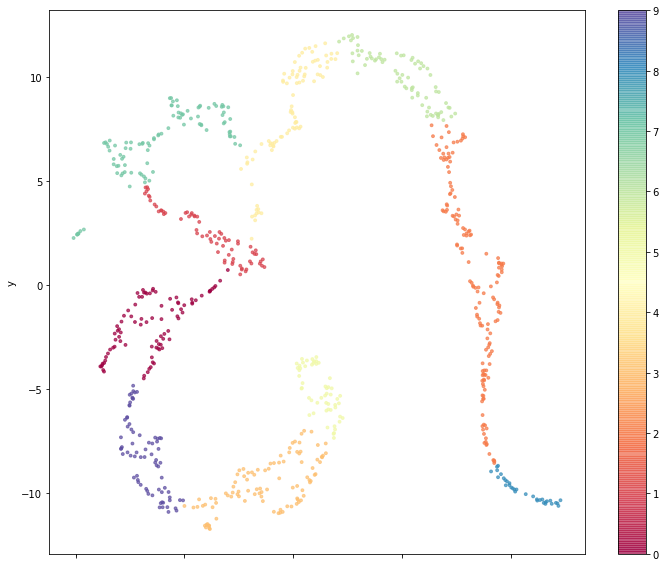

In [194]:
pd.DataFrame(umap_embedding).rename(columns={0: 'x', 1: 'y'}).plot(
    kind='scatter',
    x='x',
    y='y',
    figsize=(12,10),
    s=8,
    alpha=0.7,
    c=clusters,
    cmap='Spectral'
);

## TSNE

In [150]:
tsne = TSNE(n_components=2, random_state=42, perplexity=10, metric='euclidean')


X = extracted_features.values
tsne_embedded = tsne.fit_transform(X)

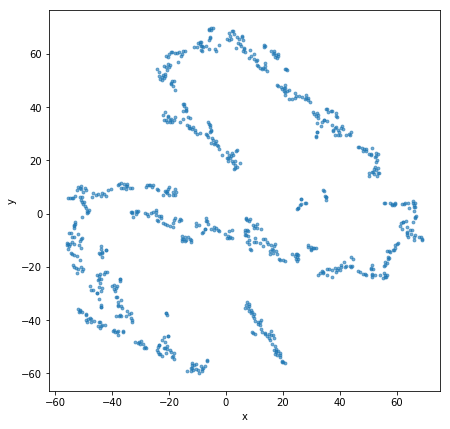

In [151]:
pd.DataFrame(tsne_embedded).rename(columns={0: 'x', 1: 'y'}).plot(
    kind='scatter',
    x='x',
    y='y',
    figsize=(7, 7),
    s=8,
    alpha=0.6
);

In [177]:
sil_scores = []

for k in range(2, 30):
    kmeans = KMeans(
        n_clusters=k,
        random_state=42
    );

    kmeans.fit(tsne_embedded);
    
    sil_score = silhouette_score(tsne_embedded, kmeans.predict(tsne_embedded))
    
    sil_scores.append((k, sil_score))   

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=9, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=11, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=12, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=13, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=14, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=15, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=16, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=17, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=18, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=19, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=21, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=22, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=23, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=24, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=25, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=26, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=27, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=28, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=29, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

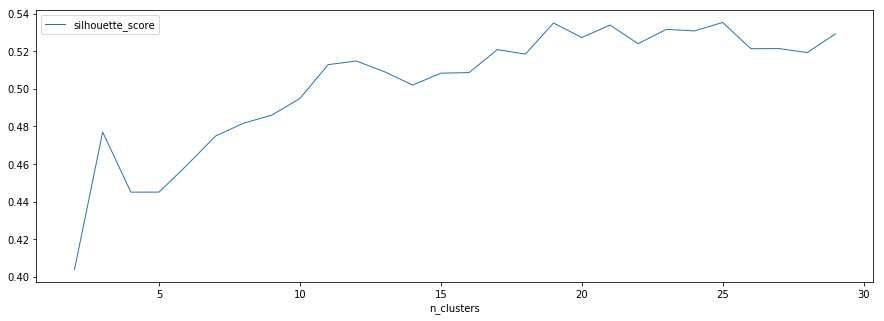

In [178]:
pd.DataFrame(sil_scores).rename(columns={0: 'n_clusters', 1: 'silhouette_score'}).plot(
    kind='line',
    lw=1,
    x='n_clusters',
    figsize=(15, 5)
);

In [179]:
pd.DataFrame(sil_scores).rename(columns={0: 'n_clusters', 1: 'silhouette_score'}).sort_values('silhouette_score', ascending=False).head(5)

,n_clusters,silhouette_score
23,25,0.535333
17,19,0.535051
19,21,0.533947
21,23,0.531652
22,24,0.530832


Choose `n_clusters == 19`

In [180]:
kmeans = KMeans(n_clusters=19, random_state=42)

clusters = kmeans.fit_predict(tsne_embedded)

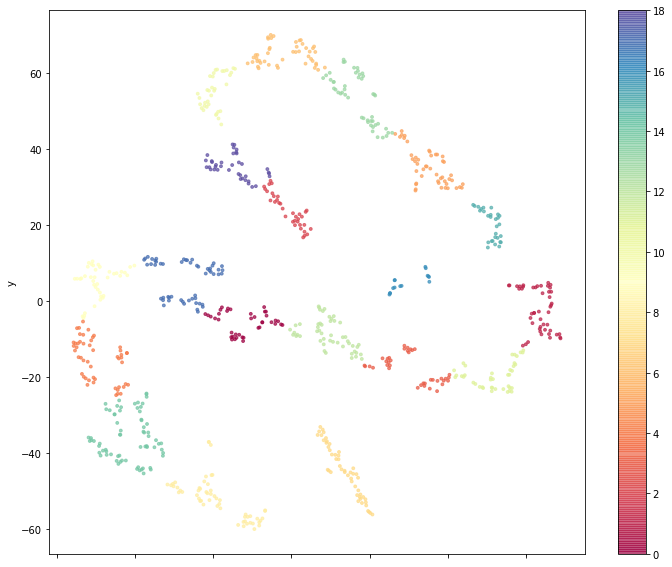

In [181]:
pd.DataFrame(tsne_embedded).rename(columns={0: 'x', 1: 'y'}).plot(
    kind='scatter',
    x='x',
    y='y',
    figsize=(12,10),
    s=8,
    alpha=0.7,
    c=clusters,
    cmap='Spectral'
);

In [191]:
gm = GaussianMixture(
    n_components=19,
    covariance_type='full',
    random_state=42
)

X = tsne_embedded
gm.fit(X)

clusters = gm.predict(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=19, n_init=1, precisions_init=None,
        random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

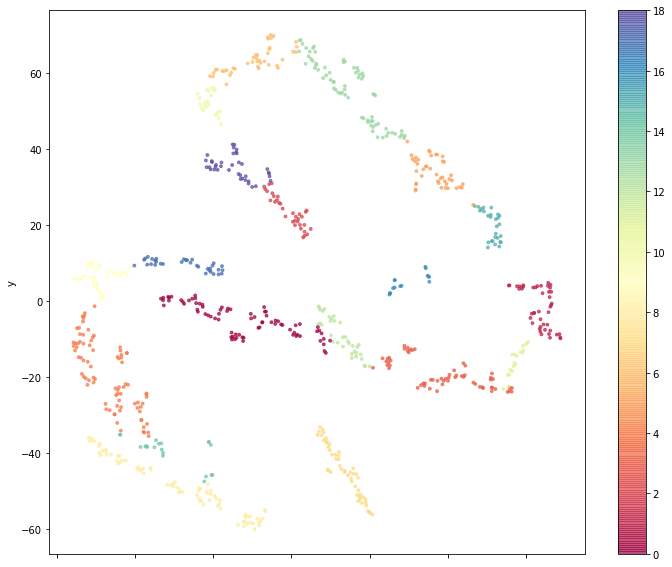

In [192]:
pd.DataFrame(tsne_embedded).rename(columns={0: 'x', 1: 'y'}).plot(
    kind='scatter',
    x='x',
    y='y',
    figsize=(12,10),
    s=8,
    alpha=0.7,
    c=clusters,
    cmap='Spectral'
);

# Outlier detection

## Isolation Forests

In [157]:
isof = IsolationForest(
    n_estimators=100,
    contamination=0.05,
    max_features=1.0,
    random_state=42
)

X = extracted_features.values

isof.fit(X)

IsolationForest(bootstrap=False, contamination=0.05, max_features=1.0,
        max_samples='auto', n_estimators=100, n_jobs=1, random_state=42,
        verbose=0)

In [158]:
isof_outliers = isof.predict(X)

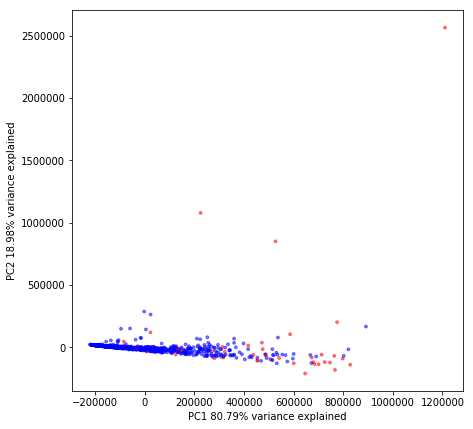

In [159]:
pc1_col = 'PC1 ' + '%.2f' % (pca.explained_variance_ratio_[0]*100) + '% variance explained'
pc2_col = 'PC2 ' + '%.2f' % (pca.explained_variance_ratio_[1]*100) + '% variance explained'

pd.DataFrame(pca_reduced).rename(columns={0: pc1_col, 1: pc2_col}).plot(
    kind='scatter',
    x=pc1_col,
    y=pc2_col,
    figsize=(7, 7),
    s=8,
    alpha=0.5,
    c=['red' if x == -1 else 'blue' for x in isof_outliers]
);

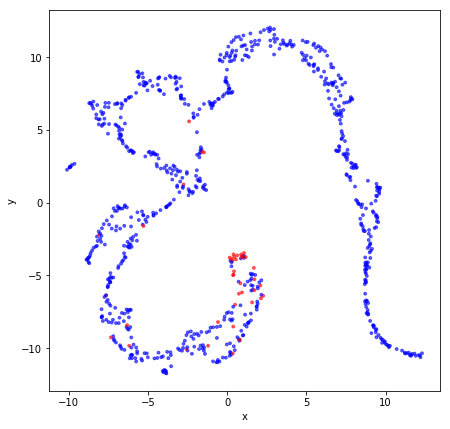

In [160]:
pd.DataFrame(umap_embedding).rename(columns={0: 'x', 1: 'y'}).plot(
    kind='scatter',
    x='x',
    y='y',
    figsize=(7,7),
    s=8,
    alpha=0.6,
    c=['red' if x == -1 else 'blue' for x in isof_outliers]
);

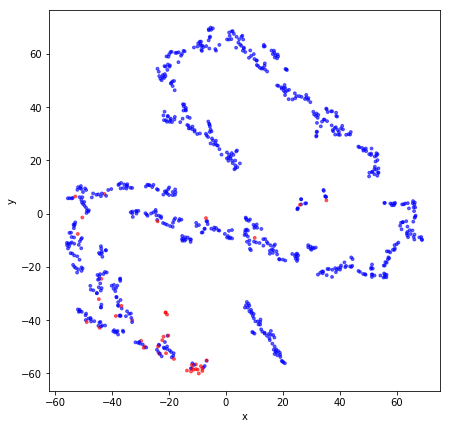

In [161]:
pd.DataFrame(tsne_embedded).rename(columns={0: 'x', 1: 'y'}).plot(
    kind='scatter',
    x='x',
    y='y',
    figsize=(7, 7),
    s=8,
    alpha=0.6,
    c=['red' if x == -1 else 'blue' for x in isof_outliers]
);